# Fitting the novel methods to REACT-1 data

This Jupyter notebook demonstrates the fitting of the novel methods to the REACT-1 data. We focus on the use of general purpose fitting functions developed for this paper, and point the reader to https://nicsteyn2.github.io/SMCforRt/ for a more comprehensive overview of the methods.

### Load the data 

We start by loading the data. We use REACT-1 study rounds 14-to-19 for now.

In [1]:
include("../src/LoadData.jl")
(Y, tMax) = loadReactData(14, 19; directory = "../data/")

(204×7 DataFrame
 Row │ t      nSamples  nPos   phat        ssw          date        Round   
     │ Int64  Int64     Int64  Float64     Float64      Date        Float64 
─────┼──────────────────────────────────────────────────────────────────────
   1 │     1      1559     12  0.00923703  0.000852675  2021-09-09     14.0
   2 │     2      2233     25  0.0120845   0.000613582  2021-09-10     14.0
   3 │     3      2049     15  0.00749267  0.000652008  2021-09-11     14.0
   4 │     4      2864     21  0.00628677  0.000465903  2021-09-12     14.0
   5 │     5      6781     44  0.00751793  0.000192453  2021-09-13     14.0
   6 │     6      7481     54  0.00856692  0.000175442  2021-09-14     14.0
   7 │     7      8367     54  0.00710912  0.000158841  2021-09-15     14.0
   8 │     8      8124     57  0.00710298  0.000161077  2021-09-16     14.0
  ⋮  │   ⋮       ⋮        ⋮        ⋮            ⋮           ⋮          ⋮
 198 │   198      2446    186  0.0761506   0.000500583  2022-03-25     

For this example, we only require the ``nSamples`` and ``nPos`` columns.

Note that the methods used assume the DataFrame contains a row for every day, even if no data were observed on a given day. See the ``nSamples = 0`` in the following rows:

In [2]:
Y[19:24,:]

,t,nSamples,nPos,phat,ssw,date,Round
,Int64,Int64,Int64,Float64,Float64,Date,Float64
1,19,3851,21,0.00596586,0.000344427,2021-09-27,14.0
2,20,349,9,0.0292376,0.00365516,2021-09-28,14.0
3,21,154,0,0.0,0.00811544,2021-09-29,14.0
4,22,6,0,0.0,0.197039,2021-09-30,14.0
5,23,0,0,0.0,0.0,2021-10-01,NaN
6,24,0,0,0.0,0.0,2021-10-02,NaN


### Specify model options

We use default model options (see the ``src/Opts.jl`` script for details):

In [3]:
include("../src/Opts.jl")
opts = fetchDefaultOpts("betabinom")

Dict{String, Any} with 18 entries:
  "ω"                          => [0.0531359, 0.0946863, 0.114096, 0.117134, 0.…
  "L"                          => 50
  "N"                          => 1000
  "pr0"                        => Uniform{Float64}(a=-0.3, b=0.3)
  "propStdDevInit"             => [0.01, 5.0e-5]
  "posteriorParamSamples"      => 100
  "chunkSize"                  => 100
  "paramPriors"                => Uniform{Float64}[Uniform{Float64}(a=0.0, b=0.…
  "initialParamSamplers"       => Uniform{Float64}[Uniform{Float64}(a=0.0, b=0.…
  "stateNames"                 => ["rt", "Pt"]
  "minESS"                     => 100
  "posteriorNumberOfParticles" => 2000
  "paramNames"                 => ["sigma", "rho"]
  "maxRhat"                    => 1.05
  "pP0"                        => missing
  "nChains"                    => 3
  "maxChunks"                  => 50
  "paramLimits"                => [(0, 0.2), (0, 0.01)]

This sets all required options, except the initial distribution for prevalence, which, in this example, depends on the observed data:

In [4]:
# Wald interval
phat = max(Y.nPos[1], 1)/Y.nSamples[1]
sd = sqrt((phat*(1-phat))/Y.nSamples[1])
opts["pP0"] = Truncated(Normal(phat, sd), 0, 1)

Truncated(Normal{Float64}(μ=0.007697241821680564, σ=0.0022134341546356695); lower=0.0, upper=1.0)

### Fitting the model

The ``fitModel()`` function is a general function that can be used to fit any of the models. It performs the following actions:

1. Estimates the standard deviation of the log-likelihood (if enabled)
2. Fits the fixed parameters using PMMH
3. Runs multiple bootstrap filter instances at these parameter values to estimate the posterior distribution of the hidden states
4. Computes the posterior predictive distribution(s)

The standard deviation of the log-likelihood is calculated at the centre of the initial parameter sample distribution (if specified) or the centre of the prior distribution on the parameters.

The function takes the following arguments:

1. A bootstrap filter function (see ``src/Models.jl`` for some pre-defined filters)
2. A DataFrame containing the observed data
3. An options dictionary

And some optional additional arguments. The ones we use here are:

- ``skipResamplingPMMH=true``: as our model is Markovian, we do not need to resample past states when estimating model likelihoods. This saves computation time.
- ``verbose=true``: prints progress updates as the model is fit
- ``posteriorPredictive="betabinom"``: Use the beta-binomial observation distribution when producing posterior predictive estimates (chosen to match our bootstrap filter)
- ``checkLogLikStdDev=true``: enables the checking of the standard deviation of the log-likelihood

In [5]:
include("../src/Models.jl") # Contains the BetaBinomialModel() bootstrap filter function
include("../src/FitModel.jl") # Contains the fitModel() function

(df_states, df_params, θ, diag) = fitModel(BetaBinomialModel, Y, opts; skipResamplingPMMH=true, verbose=true, posteriorPredictive="betabinom", checkLogLikStdDev=true);


Estimating log-likelihood multiple times...   2%|█                                                 |  ETA: 0:01:03

Estimated standard deviation of the log-likelihood: 0.607083355371639


Running chunk 1 100%|██████████████████████████████████████████████████| Time: 0:00:04


Old frobenius: 0.00010000000003125, new frobenius: 0.0010434712252826001, change: 10.434712249565154
Approx covariance matrix of parameter samples: [0.0010434700875301254 1.089575840514478e-6; 1.089575840514478e-6 8.462794752890476e-9]
2×7 DataFrame
 Row │ chunk  tuning  pAccept   Rhat     ESS       mean         std        
     │ Int64  Bool    Float64   Float64  Float64   Float64      Float64    
─────┼─────────────────────────────────────────────────────────────────────
   1 │     1    true  0.212121  1.16306  13.3926   0.0280536    0.0323282
   2 │     1    true  0.212121  1.52548   5.46773  0.000211276  8.98914e-5


Running chunk 2 100%|██████████████████████████████████████████████████| Time: 0:00:04


Old frobenius: 0.0010434712252826001, new frobenius: 0.0005751247825703085, change: 0.5511649661585534
Approx covariance matrix of parameter samples: [0.0005751241265937353 6.142110519235686e-7; 6.142110519235686e-7 5.089708005928794e-9]
2×7 DataFrame
 Row │ chunk  tuning  pAccept    Rhat     ESS      mean         std        
     │ Int64  Bool    Float64    Float64  Float64  Float64      Float64    
─────┼─────────────────────────────────────────────────────────────────────
   1 │     2    true  0.0572391  1.48437  5.82455  0.014279     0.00324953
   2 │     2    true  0.0572391  2.13391  3.90827  0.000188031  3.81843e-5


Running chunk 3 100%|██████████████████████████████████████████████████| Time: 0:00:03


Old frobenius: 0.0005751247825703085, new frobenius: 0.0003991228739221147, change: 0.693976135297773
Approx covariance matrix of parameter samples: [0.0003991225825926098 3.409738213942509e-7; 3.409738213942509e-7 5.114672320771927e-9]
2×7 DataFrame
 Row │ chunk  tuning  pAccept    Rhat     ESS      mean         std        
     │ Int64  Bool    Float64    Float64  Float64  Float64      Float64    
─────┼─────────────────────────────────────────────────────────────────────
   1 │     3    true  0.0740741  1.55341  5.43387  0.015382     0.00488092
   2 │     3    true  0.0740741  1.58586  5.18249  0.000182808  7.06898e-5


Running chunk 4 100%|██████████████████████████████████████████████████| Time: 0:00:03


Old frobenius: 0.0003991228739221147, new frobenius: 0.0003068641864814814, change: 0.7688464042814125
Approx covariance matrix of parameter samples: [0.0003068640106194913 2.3227639143198593e-7; 2.3227639143198593e-7 5.178620095880913e-9]
2×7 DataFrame
 Row │ chunk  tuning  pAccept    Rhat     ESS       mean         std        
     │ Int64  Bool    Float64    Float64  Float64   Float64      Float64    
─────┼──────────────────────────────────────────────────────────────────────
   1 │     4    true  0.0673401  1.00398  32.1894   0.0139838    0.00299045
   2 │     4    true  0.0673401  1.3286    7.80824  0.000186801  7.30649e-5


Running chunk 5 100%|██████████████████████████████████████████████████| Time: 0:00:03


Old frobenius: 0.0003068641864814814, new frobenius: 0.00024977561941050307, change: 0.8139614540049185
Approx covariance matrix of parameter samples: [0.00024977544992382686 2.0572068391642735e-7; 2.0572068391642735e-7 5.0250144018436904e-9]
2×7 DataFrame
 Row │ chunk  tuning  pAccept    Rhat     ESS      mean         std        
     │ Int64  Bool    Float64    Float64  Float64  Float64      Float64    
─────┼─────────────────────────────────────────────────────────────────────
   1 │     5    true  0.0942761  1.20595  10.523   0.0147752    0.00362425
   2 │     5    true  0.0942761  1.10666  22.7827  0.000155235  5.78091e-5


Running chunk 6 100%|██████████████████████████████████████████████████| Time: 0:00:03


Frobenius of covariance matrix: 0.00021689017931437362
Approx covariance matrix of parameter samples: [0.00021689002858360867 1.8077934900909536e-7; 1.8077934900909536e-7 4.6558025091214236e-9]
2×7 DataFrame
 Row │ chunk  tuning  pAccept    Rhat     ESS       mean         std        
     │ Int64  Bool    Float64    Float64  Float64   Float64      Float64    
─────┼──────────────────────────────────────────────────────────────────────
   1 │     6   false  0.0740741  1.2935    8.00017  0.0140213    0.00310087
   2 │     6   false  0.0740741  1.26387  10.2031   0.000173478  5.01091e-5


Running chunk 7 100%|██████████████████████████████████████████████████| Time: 0:00:03


Frobenius of covariance matrix: 0.00019143654112162422
Approx covariance matrix of parameter samples: [0.00019143641392020526 1.560158755182384e-7; 1.560158755182384e-7 4.480662879988067e-9]
2×7 DataFrame
 Row │ chunk  tuning  pAccept  Rhat     ESS      mean         std        
     │ Int64  Bool    Float64  Float64  Float64  Float64      Float64    
─────┼───────────────────────────────────────────────────────────────────
   1 │     7   false  0.10101  1.14088  15.5256  0.0143022    0.00306427
   2 │     7   false  0.10101  1.23795  10.5424  0.000187691  5.64598e-5


Running chunk 8 100%|██████████████████████████████████████████████████| Time: 0:00:03


Frobenius of covariance matrix: 0.00017180145298202146
Approx covariance matrix of parameter samples: [0.00017180134683491096 1.3500762035341098e-7; 1.3500762035341098e-7 4.281267517075423e-9]
2×7 DataFrame
 Row │ chunk  tuning  pAccept    Rhat     ESS      mean         std        
     │ Int64  Bool    Float64    Float64  Float64  Float64      Float64    
─────┼─────────────────────────────────────────────────────────────────────
   1 │     8   false  0.0942761  1.06323  55.3444  0.0142669    0.00317341
   2 │     8   false  0.0942761  1.06437  34.0955  0.000190787  5.47424e-5


Running chunk 9 100%|██████████████████████████████████████████████████| Time: 0:00:03


Frobenius of covariance matrix: 0.00015655881165458024
Approx covariance matrix of parameter samples: [0.00015655873470454105 1.0971335202502211e-7; 1.0971335202502211e-7 4.513119060351384e-9]
2×7 DataFrame
 Row │ chunk  tuning  pAccept   Rhat     ESS       mean         std        
     │ Int64  Bool    Float64   Float64  Float64   Float64      Float64    
─────┼─────────────────────────────────────────────────────────────────────
   1 │     9   false  0.144781  1.01944  120.789   0.0147875    0.00370202
   2 │     9   false  0.144781  1.10763   25.2315  0.000192167  6.34846e-5


Running chunk 10 100%|██████████████████████████████████████████████████| Time: 0:00:03


Frobenius of covariance matrix: 0.00014375766169411164
Approx covariance matrix of parameter samples: [0.00014375760604350962 8.93851488717993e-8; 8.93851488717993e-8 4.581273145431465e-9]
2×7 DataFrame
 Row │ chunk  tuning  pAccept   Rhat     ESS       mean         std        
     │ Int64  Bool    Float64   Float64  Float64   Float64      Float64    
─────┼─────────────────────────────────────────────────────────────────────
   1 │    10   false  0.124579  1.00696  136.627   0.014812     0.00365553
   2 │    10   false  0.124579  1.08008   47.4066  0.000195495  6.58228e-5


Running chunk 11 100%|██████████████████████████████████████████████████| Time: 0:00:03


Frobenius of covariance matrix: 0.00013275054123658257
Approx covariance matrix of parameter samples: [0.0001327504929428733 8.00100374896293e-8; 8.00100374896293e-8 4.337921162063596e-9]
2×7 DataFrame
 Row │ chunk  tuning  pAccept  Rhat     ESS       mean         std        
     │ Int64  Bool    Float64  Float64  Float64   Float64      Float64    
─────┼────────────────────────────────────────────────────────────────────
   1 │    11   false  0.13468  1.00527  170.514   0.0147085    0.00353487
   2 │    11   false  0.13468  1.03234   52.0558  0.000193533  6.19113e-5


Running chunk 12 100%|██████████████████████████████████████████████████| Time: 0:00:03


Frobenius of covariance matrix: 0.0001237595297597144
Approx covariance matrix of parameter samples: [0.00012375949165131976 6.86062905734064e-8; 6.86062905734064e-8 4.3481416975883714e-9]
2×7 DataFrame
 Row │ chunk  tuning  pAccept   Rhat     ESS       mean         std        
     │ Int64  Bool    Float64   Float64  Float64   Float64      Float64    
─────┼─────────────────────────────────────────────────────────────────────
   1 │    12   false  0.178451  1.00561  186.196   0.0148552    0.00360806
   2 │    12   false  0.178451  1.04248   66.5529  0.000195898  6.22003e-5


Running chunk 13 100%|██████████████████████████████████████████████████| Time: 0:00:03


Frobenius of covariance matrix: 0.00011621271496466479
Approx covariance matrix of parameter samples: [0.00011621268834167807 5.553634820799388e-8; 5.553634820799388e-8 4.391637679212915e-9]
2×7 DataFrame
 Row │ chunk  tuning  pAccept   Rhat     ESS       mean         std        
     │ Int64  Bool    Float64   Float64  Float64   Float64      Float64    
─────┼─────────────────────────────────────────────────────────────────────
   1 │    13   false  0.181818  1.00686  234.511   0.0148777    0.00370877
   2 │    13   false  0.181818  1.05504   74.3261  0.000197375  6.37315e-5


Running chunk 14 100%|██████████████████████████████████████████████████| Time: 0:00:03


Frobenius of covariance matrix: 0.00010923168981737634
Approx covariance matrix of parameter samples: [0.00010923166819038909 4.85102067038794e-8; 4.85102067038794e-8 4.268951996781844e-9]
2×7 DataFrame
 Row │ chunk  tuning  pAccept    Rhat     ESS       mean         std        
     │ Int64  Bool    Float64    Float64  Float64   Float64      Float64    
─────┼──────────────────────────────────────────────────────────────────────
   1 │    14   false  0.0942761  1.00557  251.544   0.0147418    0.00364899
   2 │    14   false  0.0942761  1.04637   97.6181  0.000196672  6.25262e-5


Running chunk 15 100%|██████████████████████████████████████████████████| Time: 0:00:03


Frobenius of covariance matrix: 0.00010301515727486062
Approx covariance matrix of parameter samples: [0.00010301513670649424 4.5934398795090254e-8; 4.5934398795090254e-8 4.2152799476668105e-9]
2×7 DataFrame
 Row │ chunk  tuning  pAccept   Rhat     ESS      mean         std        
     │ Int64  Bool    Float64   Float64  Float64  Float64      Float64    
─────┼────────────────────────────────────────────────────────────────────
   1 │    15   false  0.154882  1.00126  288.145  0.0147177    0.00360659
   2 │    15   false  0.154882  1.03832  105.011  0.000195129  6.23128e-5
Model finished. Time elapsed: 73.6 seconds


### Interpreting the results:

We start by interrogating the PMMH output:

In [6]:
display(df_params)

,param,m,l,u,rhat,ess
,String,Float64,Float64,Float64,Float64,Float64
1,sigma,0.0147177,0.00891772,0.0231638,1.00126,288.145
2,rho,0.000195129,7.86347e-5,0.000339779,1.03832,105.011


Which shows that $\sigma = 0.015 \ (0.09, 0.023)$ and $\rho = 1.9 \ (0.8, 3.4) \times 10^{-4}$.

We can also plot the central estimates and credible intervals of the posterior distributions of the hidden states:

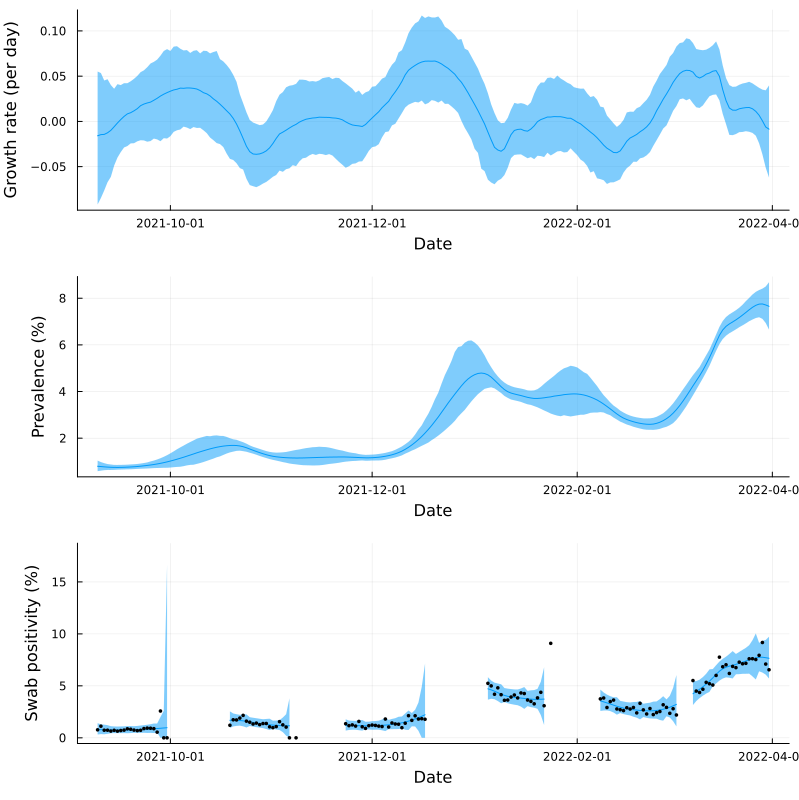

GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA


In [7]:
using Plots, Measures

rt = df_states[df_states.variable .== "rt",:]
Pt = df_states[df_states.variable .== "Pt",:]
ObsPos = df_states[df_states.variable .== "Obs positivity",:]

plt_rt = plot(rt.date, rt.mean, ribbon=(rt.mean-rt.lower, rt.upper-rt.mean), xlabel="Date", ylabel="Growth rate (per day)", label=false)
plt_Pt = plot(Pt.date, 100*Pt.mean, ribbon=(100*Pt.mean-100*Pt.lower, 100*Pt.upper-100*Pt.mean), xlabel="Date", ylabel="Prevalence (%)", label=false)
plt_ObsPos = plot(ObsPos.date, 100*ObsPos.mean, ribbon=(100*ObsPos.mean-100*ObsPos.lower, 100*ObsPos.upper-100*ObsPos.mean), xlabel="Date", ylabel="Swab positivity (%)", label=false)
plt_ObsPos = plot!(plt_ObsPos, Y.date, 100*Y.nPos./Y.nSamples, seriestype=:scatter, label="Observed positivity (%)", markersize=2, color=:black)

plt = plot(plt_rt, plt_Pt, plt_ObsPos, layout=(3,1), size=(800,800), legend=false, margins=0.5mm)